In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path('').absolute().parent))

In [2]:
import joblib
import numpy as np
import seaborn as sns
import shap
from scipy import sparse
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.utils.validation import check_is_fitted

# Paths

In [3]:
ROOT = Path('..')
MODELS_DIR = ROOT / 'models'
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

# Load data splits

In [4]:
# TODO: move to utils
def load_data_splits(*, data_dir, split):
    if split not in ['train', 'test']:
        raise ValueError('`split` should be either `train` or `test`')
    
    X = sparse.load_npz(data_dir / split / f'sparse_{split}_X.npz')\
        .toarray()
    y = sparse.load_npz(data_dir / split / f'sparse_{split}_y.npz')\
        .toarray()\
        .squeeze()
    
    return X, y

In [5]:
train_X, train_y = load_data_splits(data_dir=RAW_DATA_DIR, split='train')
test_X, test_y = load_data_splits(data_dir=RAW_DATA_DIR, split='test')

# print shapes to confirm
for split in ['train_X', 'train_y', 'test_X', 'test_y']:
    print('{name}: {shape}'.format(name=split, shape=eval(split).shape))

train_X: (4140, 2048)
train_y: (4140,)
test_X: (1035, 2048)
test_y: (1035,)


# Load best model

In [6]:
best_model_path = MODELS_DIR / 'model_gb.joblib'
model = joblib.load(best_model_path)
check_is_fitted(model)
model

GradientBoostingClassifier(learning_rate=0.3935910935564404, max_depth=14,
                           min_samples_leaf=17, n_estimators=155,
                           random_state=123)

In [7]:
model_tuned_params = dict(
    learning_rate=0.3935911,
    max_depth=14,
    min_samples_leaf=17,
    n_estimators=155,
    random_state=123
)

# Benchmark performance on test set

In [8]:
test_pred = model.predict(test_X)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y, test_pred))

Accuracy on test set: 0.8406
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       324
           1       0.88      0.90      0.89       711

    accuracy                           0.84      1035
   macro avg       0.82      0.81      0.81      1035
weighted avg       0.84      0.84      0.84      1035



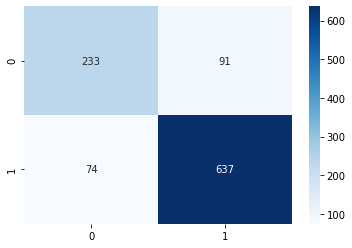

In [9]:
sns.heatmap(confusion_matrix(test_y, test_pred),
            cmap='Blues', annot=True, fmt='d');

# Using SHAP for explanations

In [10]:
def get_top_bits(shap_values, n):
    importances = np.abs(shap_values).mean(0)
    return list(reversed(np.argsort(importances)))[:n]

## On test features

In [11]:
feature_names = [*map(lambda x: 'bit_{}'.format(x),
                      range(test_X.shape[1]))]
explainer = shap.Explainer(model,
                           feature_names=feature_names)
shap_explanation = explainer(train_X)

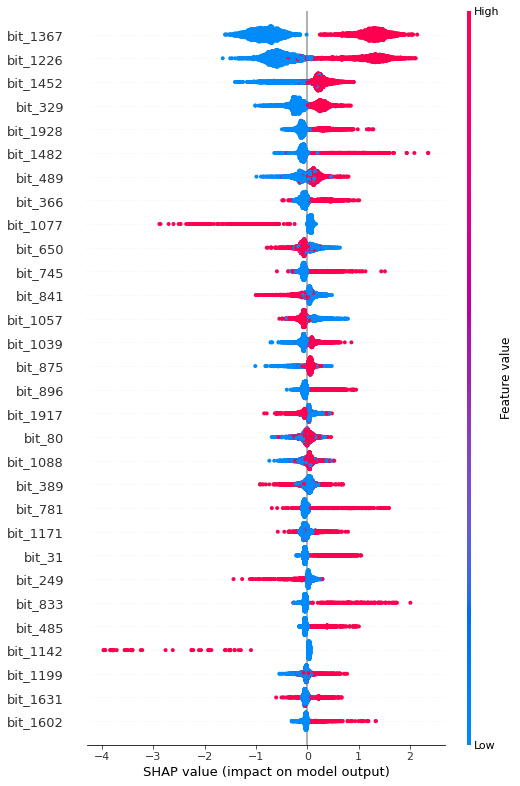

In [12]:
# nummary_plot explaining target class at index 0
shap.summary_plot(shap_explanation, train_X, max_display=30)

### Bar plot
Summarize the effects of features accross all instances

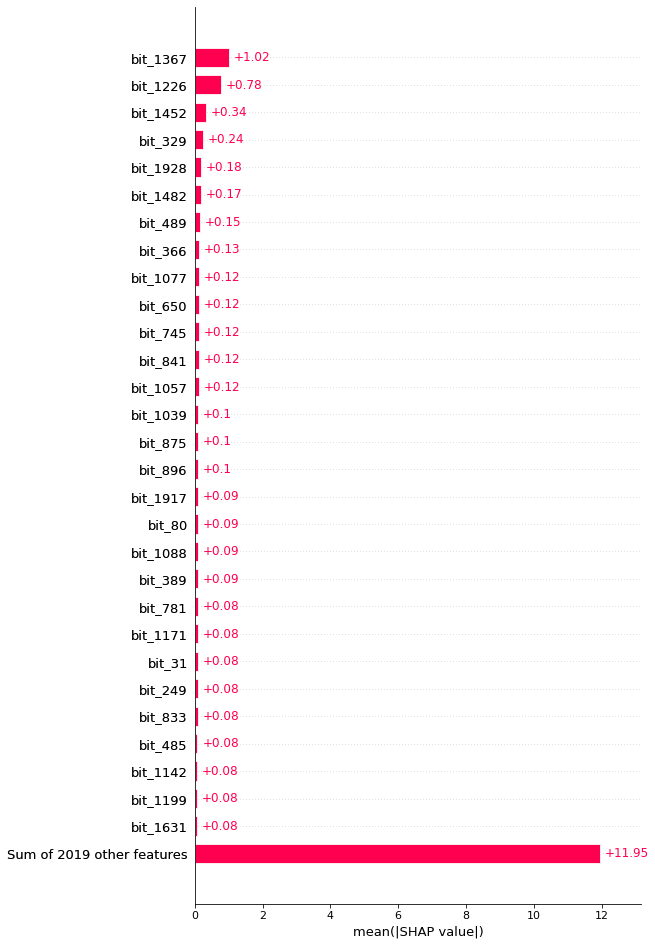

In [13]:
shap.plots.bar(shap_explanation, max_display=30)

As expected from ensembles (specially boosted trees), feature contributions "add up" to get a prediction result. Hence, the overall contribution of each feature tends to be small, and spread across many of them. However, in this scenario we clearly have two features standind out.

In [14]:
top_10_bits = get_top_bits(shap_explanation.values, n=10)
top_10_bits

[1367, 1226, 1452, 329, 1928, 1482, 489, 366, 1077, 650]

# Visualize most important bits as molecule fragments

In [20]:
import json
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import (Draw,
                        Descriptors,
                        AllChem)

In [16]:
df_smiles = pd.read_csv(DATA_DIR / 'egfr_erbB1_smiles.csv', index_col=0)
df_smiles.head()

,chembid,smiles_notation
0,CHEMBL301018,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC
1,CHEMBL281543,C=CC(=O)Nc1nc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1CCCCN...
2,CHEMBL401930,Cc1cc(N2CCOCC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc...
3,CHEMBL274654,Cc1[nH]c(/C=C2\C(=O)Nc3ccccc32)c(C)c1CCC(=O)O
4,CHEMBL382822,COc1cc2ncnc(Nc3cccc(Cl)c3F)c2cc1CN1CCC[C@@H]1C...


In [17]:
with open(DATA_DIR / 'bit_info.json', 'r') as file:
    chembl_to_bitinfo = json.load(file)

print('Sample elem from map:')
[{k: v} for k, v in chembl_to_bitinfo.items()][0]

Sample elem from map:


{'CHEMBL301018': {'191': [[10, 1]],
  '216': [[12, 2]],
  '249': [[1, 2], [21, 2]],
  '329': [[10, 2]],
  '366': [[15, 1]],
  '378': [[5, 0], [7, 0]],
  '465': [[13, 2]],
  '489': [[6, 1]],
  '491': [[9, 1]],
  '561': [[16, 1]],
  '673': [[4, 2]],
  '695': [[1, 0], [21, 0]],
  '699': [[14, 1]],
  '708': [[8, 1]],
  '780': [[3, 2]],
  '794': [[8, 2]],
  '841': [[0, 1], [22, 1]],
  '843': [[11, 2]],
  '875': [[3, 1], [19, 1], [17, 1]],
  '888': [[9, 2]],
  '1057': [[0, 0], [22, 0]],
  '1097': [[4, 1]],
  '1152': [[9, 0]],
  '1157': [[18, 2]],
  '1226': [[5, 2]],
  '1245': [[2, 2], [20, 2]],
  '1357': [[18, 1]],
  '1367': [[7, 2]],
  '1380': [[2, 0],
   [4, 0],
   [8, 0],
   [10, 0],
   [13, 0],
   [15, 0],
   [18, 0],
   [20, 0]],
  '1452': [[5, 1], [7, 1]],
  '1488': [[15, 2]],
  '1536': [[1, 1], [21, 1]],
  '1581': [[17, 2]],
  '1648': [[19, 2]],
  '1683': [[16, 0]],
  '1750': [[11, 1], [12, 1]],
  '1810': [[6, 2]],
  '1840': [[13, 1]],
  '1873': [[3, 0], [6, 0], [11, 0], [12, 0], [17,

In [18]:
# funções de conveniência
def get_mol(chembl, df_smiles):
    smiles = df_smiles[df_smiles['chembid'] == chembl].iloc[0,1]
    mol = Chem.MolFromSmiles(smiles)
    return mol

Bit 1367 ----------------------------------------------


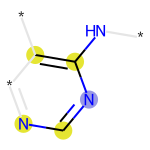

Bit 1226 ----------------------------------------------


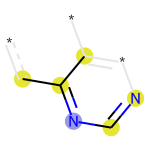

Bit 1452 ----------------------------------------------


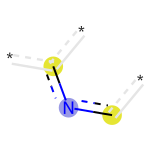

Bit 329 -----------------------------------------------


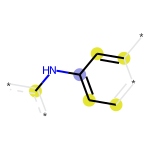

Bit 1928 ----------------------------------------------


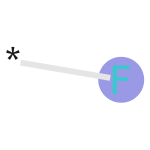

Bit 1482 ----------------------------------------------


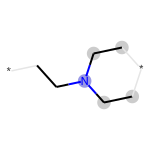

Bit 489 -----------------------------------------------


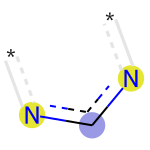

Bit 366 -----------------------------------------------


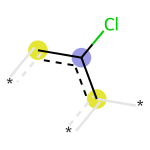

Bit 1077 ----------------------------------------------


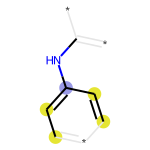

Bit 650 -----------------------------------------------


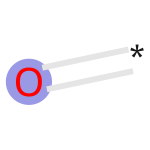

In [21]:
for bit_num in top_10_bits:
    search_bit = str(bit_num)
    print('Bit {}'.format(search_bit), '-'*(50 - len(search_bit)))

    # get bit info corresponding to it
    chemblid, bi = [(_id, bit_info) for _id, bit_info in chembl_to_bitinfo.items()
                    if search_bit in list(bit_info.keys())][0]
    
    search_mol = get_mol(chemblid, df_smiles)
    bit_img = Draw.DrawMorganBit(search_mol, search_bit, bi, useSVG=True)
    display(bit_img)